# Environment Set Up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import ensemble, tree, metrics
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from io import StringIO  
from IPython.display import Image  
import pydotplus
%matplotlib inline
data = pd.ExcelFile('DataDownload.xls')

Re-creating the master dataframe.

In [2]:
assistance = data.parse('ASSISTANCE')
assistance_sub = assistance[['State',
                             'County',
                             'REDEMP_SNAPS12',
                             'PCT_SNAP12',
                             'PC_SNAPBEN10',
                             'PC_SNAPBEN15',
                             'SNAP_PART_RATE13',
                             'PCT_FREE_LUNCH14',
                             'PCT_REDUCED_LUNCH14',
                             'PC_WIC_REDEMP12',
                             'REDEMP_WICS12'
                            ]]

In [3]:
access = data.parse('ACCESS')
access_sub = access[['State',
                     'County',
                     'LACCESS_POP10',
                     'PCT_LACCESS_POP10',
                     'LACCESS_LOWI10',
                     'PCT_LACCESS_LOWI10',
                     'LACCESS_HHNV10',
                     'PCT_LACCESS_HHNV10',
                     'LACCESS_SNAP15',
                     'PCT_LACCESS_SNAP15',
                     'LACCESS_CHILD10',
                     'PCT_LACCESS_CHILD10',
                     'LACCESS_SENIORS10',
                     'PCT_LACCESS_SENIORS10'
                     ]]

In [4]:
stores = data.parse('STORES')
stores_sub = stores[['State',
                     'County',
                     'GROC14',
                     'GROCPTH14',
                     'SUPERC14',
                     'SUPERCPTH14',
                     'CONVS14',
                     'CONVSPTH14',
                     'SPECS14',
                     'SPECSPTH14',
                     'SNAPS12',
                     'SNAPSPTH12',
                     'WICS12',
                     'WICSPTH12'
                    ]]

In [5]:
restaurants = data.parse('RESTAURANTS')
restaurants_sub = restaurants[['State',
                               'County',
                               'FFR14',
                               'FFRPTH14',
                               'FSR14',
                               'FSRPTH14',
                               'PC_FFRSALES12',
                               'PC_FSRSALES12'
                              ]]

In [6]:
insecurity = data.parse('INSECURITY')
insecurity_sub = insecurity[['State',
                             'County',
                             'FOODINSEC_10_12',
                             'VLFOODSEC_10_12',
                             'FOODINSEC_CHILD_03_11'
                            ]]

In [7]:
df = data.parse('Supplemental Data - County')
county = df[['State', 'County', '2010 Census Population', 'Population Estimate, 2011', 
              'Population Estimate, 2012', 'Population Estimate, 2013', 
              'Population Estimate, 2014', 'Population Estimate, 2015']].copy()

# Convert strings in pandas series (columns in the dataframe) where values containe a comma into numerical values.

def remove_comma_from_series(var):
    """Parameters
        ---------
        var: pandas Series
        
        For each element of the series, this function will replace every instance of a comma with nothing,
        as represented by the empty quotation marks.  It will then turn the resulting string into an integer.
        Finally, it will return the integer.
    """
    
    new_var = [int(x.replace(",", "")) for x in var ]
    
    return new_var

# The first two columns list the state and country rather than any numeric values,
# so they'd trigger errors in our function.
# I'm sure there's a prettier way of skipping them than plugging the function into a try-except block,
# but it works.

for x in county:
    try:
        county[x] = remove_comma_from_series(county[x])
    except:
        continue

In [8]:
master = county.merge(assistance_sub, on = ['State', 'County'])\
    .merge(access_sub, on = ['State', 'County'])\
    .merge(stores_sub, on = ['State', 'County'])\
    .merge(restaurants_sub, on = ['State', 'County'])\
    .merge(insecurity, on = ['State', 'County'])

In [9]:
master_subset = master[['2010 Census Population', 'PC_SNAPBEN10', 'PC_SNAPBEN15',
                             'REDEMP_SNAPS12',
                             'PCT_SNAP12',
                             'PCT_FREE_LUNCH14',
                             'PC_WIC_REDEMP12',
                             'PCT_LACCESS_HHNV10',
                             'PCT_LACCESS_SNAP15',
                             'SNAPSPTH12']].copy()

Let's take a look at our features here.

In [10]:
master_subset.describe()

,2010 Census Population,PC_SNAPBEN10,PC_SNAPBEN15,REDEMP_SNAPS12,PCT_SNAP12,PCT_FREE_LUNCH14,PC_WIC_REDEMP12,PCT_LACCESS_HHNV10,PCT_LACCESS_SNAP15,SNAPSPTH12
count,3.545000e+03,3323.000000,3322.000000,3.303000e+03,3545.000000,3261.000000,2329.000000,3545.000000,3510.000000,3545.000000
mean,1.254355e+05,19.170410,18.193191,2.604695e+05,14.792725,46.809334,18.833608,3.089957,2.900668,0.892714
std,3.303254e+05,10.064305,10.016449,1.285998e+05,3.578200,19.628149,9.649484,3.156376,3.340849,0.394623
min,8.200000e+01,1.013588,0.863202,0.000000e+00,5.866367,0.000000,0.139449,0.000000,0.000000,0.000000
25%,1.167700e+04,11.532682,11.000109,1.682281e+05,11.167431,32.870339,12.803340,1.494702,1.039961,0.619041
50%,2.874400e+04,17.850521,16.368016,2.568591e+05,15.223027,43.826889,17.167160,2.467509,2.031962,0.828739
75%,8.883000e+04,24.731519,23.298009,3.372874e+05,17.517380,56.975381,22.690820,3.767519,3.563250,1.090513
max,9.818605e+06,76.284852,100.139353,1.253321e+06,22.131516,100.000000,131.366500,68.470405,37.254488,6.658001


What we're trying to do will require that there be no null values within our dataset, so let's check that.

In [11]:
master_subset.isna().sum()

2010 Census Population       0
PC_SNAPBEN10               222
PC_SNAPBEN15               223
REDEMP_SNAPS12             242
PCT_SNAP12                   0
PCT_FREE_LUNCH14           284
PC_WIC_REDEMP12           1216
PCT_LACCESS_HHNV10           0
PCT_LACCESS_SNAP15          35
SNAPSPTH12                   0
dtype: int64

PC_WIC_REDEMP12 looks like it's going to be a problem, but we've got more important things to sort out first.  There's no use in predicting values that don't exist, so let's drop the null values from our target feature.

In [12]:
master_subset.dropna(subset='PC_SNAPBEN15', inplace=True)

Now let's take a look at how much of the columns are missing, percentage-wise.

In [13]:
master_subset.isna().mean()

2010 Census Population    0.000000
PC_SNAPBEN10              0.000602
PC_SNAPBEN15              0.000000
REDEMP_SNAPS12            0.067429
PCT_SNAP12                0.000000
PCT_FREE_LUNCH14          0.076159
PC_WIC_REDEMP12           0.337146
PCT_LACCESS_HHNV10        0.000000
PCT_LACCESS_SNAP15        0.007827
SNAPSPTH12                0.000000
dtype: float64

PC_WIC_REDEMP12 is missing roughly a third of the data, so we'll handle that separately, but the rest can probably be filled with just the mean of each column.  If you want more precise data you may want to consier looking at the values broken down by region or state, but we don't need to be that granular here.

In [14]:
columns = ['2010 Census Population', 'PC_SNAPBEN10',
                             'REDEMP_SNAPS12',
                             'PCT_SNAP12',
                             'PCT_FREE_LUNCH14',
                              'PCT_LACCESS_HHNV10',
                             'PCT_LACCESS_SNAP15',
                             'SNAPSPTH12']
for c in columns:
    master_subset[c].fillna(master_subset[c].mean(), inplace=True)

In [15]:
master_subset.isna().mean()

2010 Census Population    0.000000
PC_SNAPBEN10              0.000000
PC_SNAPBEN15              0.000000
REDEMP_SNAPS12            0.000000
PCT_SNAP12                0.000000
PCT_FREE_LUNCH14          0.000000
PC_WIC_REDEMP12           0.337146
PCT_LACCESS_HHNV10        0.000000
PCT_LACCESS_SNAP15        0.000000
SNAPSPTH12                0.000000
dtype: float64

Much better.  Now let's look closer at our problem column.

(array([5.940e+02, 1.249e+03, 2.980e+02, 4.900e+01, 5.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.1394494 ,  13.26215446,  26.38485952,  39.50756458,
         52.63026964,  65.7529747 ,  78.87567976,  91.99838482,
        105.12108988, 118.24379494, 131.3665    ]),
 <BarContainer object of 10 artists>)

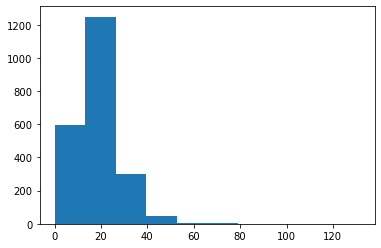

In [16]:
plt.hist(master_subset['PC_WIC_REDEMP12'])

In [17]:
master_subset['PC_WIC_REDEMP12'].describe()

count    2202.000000
mean       18.944331
std         9.373263
min         0.139449
25%        12.918743
50%        17.304405
75%        22.959302
max       131.366500
Name: PC_WIC_REDEMP12, dtype: float64

It's not as bad as it could have been; there are some extreme values on the high end, so it seems like if we just substitute the median for the mean, that should do well enough for our purposes

In [18]:
master_subset.fillna(value=master_subset['PC_WIC_REDEMP12'].median(), inplace=True)

In [19]:
master_subset.isna().mean()

2010 Census Population    0.0
PC_SNAPBEN10              0.0
PC_SNAPBEN15              0.0
REDEMP_SNAPS12            0.0
PCT_SNAP12                0.0
PCT_FREE_LUNCH14          0.0
PC_WIC_REDEMP12           0.0
PCT_LACCESS_HHNV10        0.0
PCT_LACCESS_SNAP15        0.0
SNAPSPTH12                0.0
dtype: float64

Now we can really get to work.

<AxesSubplot:>

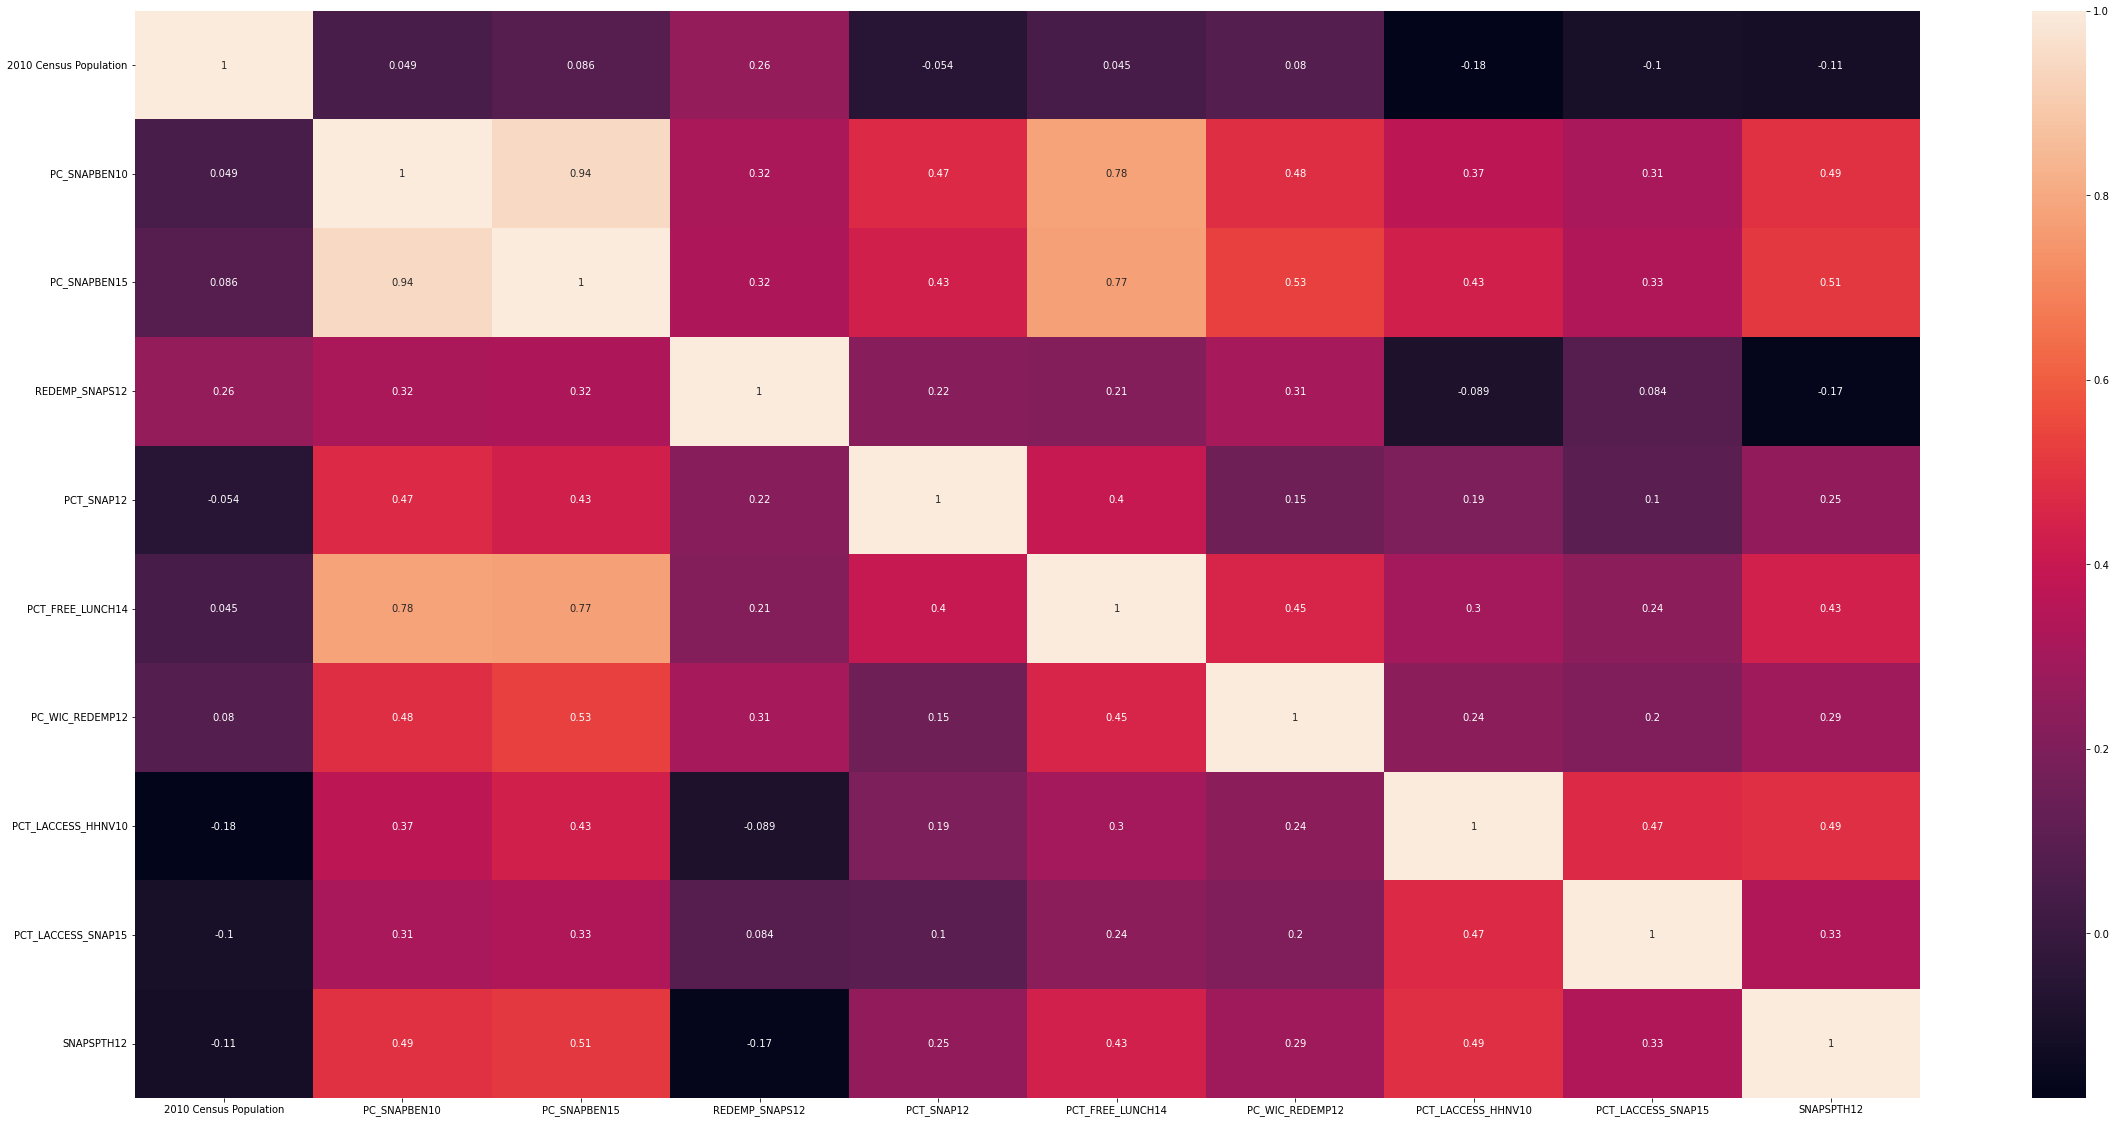

In [20]:
plt.figure(figsize=(40, 20))
sns.heatmap(master_subset.corr(), annot=True)

The heatmap above gives us a rough idea of what we're looking at; unsurprisingly, the strongest correlations are between PC_SNAPBEN10 and PC_SNAPBEN15, though PCT_FREE_LUNCH14 also stands out with a correlation of .77.  PC_WIC_REDEMP12 and SNAPSPTH12 both have correlations of slightly over .50, and the rest hover between low .4 and .3, so they may still be of use.

Let's start with just PC_SNAPBEN10 and PC_SNAPBEN15, using a linear regression.  It's good to start with something simple, and the relationship between them seems to be mostly linear.

In [21]:
X = master_subset[['PC_SNAPBEN10']]
y = master_subset[['PC_SNAPBEN15']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2491, 1) (2491, 1)
(831, 1) (831, 1)


In [23]:
rModel = linear_model.LinearRegression(normalize=True)

In [24]:
rModel.fit(X_train, y_train)

C:\Users\Andy\miniconda3\envs\testbed\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [25]:
print(rModel.score(X_train, y_train))

0.8920743467708191


In [26]:
y_pred = rModel.predict(X_test)

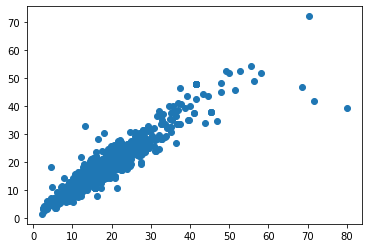

In [27]:
plt.scatter(y_test,y_pred)

As you can see above, there's a fairly clear linear relationship between PC_SNAPBEN10 and PC_SNAPBEN15, though there certainly are some outliers.  This should give us a decent baseline: it's a simple but effective model, and so any more complicated model will have to do better than this to be worth using.  "Better" is, of course, a vague term, so for the purposes of this project when I say "better" I mean we will try to minimise the mean squared error, as this will give us a quantifiable metric to compare all the models we generate.

In [28]:
print(rModel.score(X_test, y_test))

0.8789014575983095


In [29]:
metrics.mean_squared_error(y_test, y_pred)

12.641348655101416

Now that we have a mean squared error of about 12.64, we can start exploring more complicated models to see if we can do better.  Let's start with multivariable regression, as it can hopefully use some of the other features to make the model more accurate.

In [30]:
#multivariable regresion
#trying to find a function that beats the one-variable model above

X = master_subset[['2010 Census Population', 'PC_SNAPBEN10',
                            'REDEMP_SNAPS12',
                            'PCT_SNAP12',
                            'PCT_FREE_LUNCH14',
                            'PC_WIC_REDEMP12',
                            'PCT_LACCESS_HHNV10',
                            'PCT_LACCESS_SNAP15',
                            'SNAPSPTH12']]
y = master_subset[['PC_SNAPBEN15']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [31]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2491, 9) (2491, 1)
(831, 9) (831, 1)


In [32]:
rModel = linear_model.LinearRegression(normalize=True)

In [33]:
rModel.fit(X_train, y_train)

C:\Users\Andy\miniconda3\envs\testbed\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [34]:
print(rModel.score(X_train, y_train))

0.9110754368506175


In [35]:
y_pred = rModel.predict(X_test)

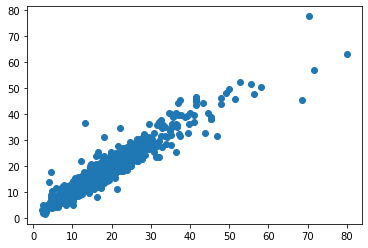

In [36]:
plt.scatter(y_test,y_pred)

In [37]:
print(rModel.score(X_test, y_test))

0.9050350035838581


In [38]:
metrics.mean_squared_error(y_test, y_pred)

9.913295452763

Including more features maintaines a linear shape, but this time the mean squared error is about 9.91; a distinct improvement.  Since there is concern over data leakage as a result of using data collected in 2015, specifically the PCT_LACCESS_SNAP15 feature, let's see how the model looks without it.

In [39]:
#Same as above, but removing PCT_LACCESS_SNAP15
X = master_subset[['2010 Census Population', 'PC_SNAPBEN10',
                            'REDEMP_SNAPS12',
                            'PCT_SNAP12',
                            'PCT_FREE_LUNCH14',
                            'PC_WIC_REDEMP12',
                            'PCT_LACCESS_HHNV10',
                            'SNAPSPTH12']]
y = master_subset[['PC_SNAPBEN15']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [40]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2491, 8) (2491, 1)
(831, 8) (831, 1)


In [41]:
rModel = linear_model.LinearRegression(normalize=True)

In [42]:
rModel.fit(X_train, y_train)

C:\Users\Andy\miniconda3\envs\testbed\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [43]:
print(rModel.score(X_train, y_train))

0.9110374469428809


In [44]:
y_pred = rModel.predict(X_test)

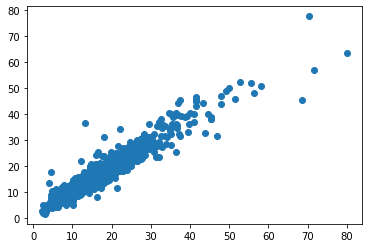

In [45]:
plt.scatter(y_test,y_pred)

In [46]:
print(rModel.score(X_test, y_test))

0.905447464577289


In [47]:
metrics.mean_squared_error(y_test, y_pred)

9.870239086260312

Removing the possible confounding factor has actually improved the model's performance slightly from 9.91 down to 9.87.  Since the model dosn't seem to overly rely on it, and to avoid data leakage, let's remove that feature from consideration going forward.  Let's try another method: decision tree regression.

In [48]:
# Declare a variable called entr_model and use tree.DecisionTreeRegressor. 
entr_model = tree.DecisionTreeRegressor(random_state = 1234)

# Call fit() on entr_model
entr_model.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = entr_model.predict(X_test)

# Call Series on our y_pred variable with the following: pd.Series(y_pred)
y_pred = pd.Series(y_pred)

# Check out entr_model
entr_model

#look up: DecisionTreeRegressor
#rmse on all algorithms: linear regression and Decision Tree, maybe try random forest after

DecisionTreeRegressor(random_state=1234)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.182107 to fit



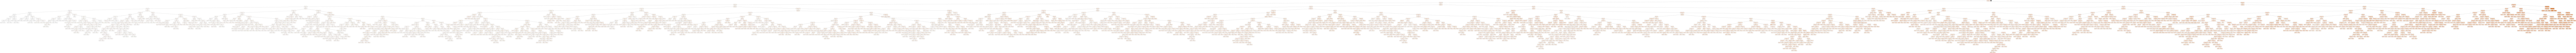

In [49]:
# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(entr_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["NO", "YES"]) 

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [50]:
metrics.mean_squared_error(y_test, y_pred)

10.929377934229263

The decision tree regressor gave us a mean squared error of about 10.93; when running the same algorithm including PCT_LACCESS_SNAP15, the resulting model performed better than this with a mean squared error of 10.09.  Both are better than the original algorithm, but they are still outclassed by multivariable regression.  The random forest algorithm is based on averaging randomized decision trees, so let's see if it can do better.

In [51]:
forest_model = ensemble.RandomForestRegressor(random_state = 1234)
# Call fit() on entr_model
forest_model.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = forest_model.predict(X_test)

# Call Series on our y_pred variable with the following: pd.Series(y_pred)
y_pred = pd.Series(y_pred)

# Check out entr_model
forest_model

C:\Users\Andy\AppData\Local\Temp\ipykernel_9652\1369036707.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_model.fit(X_train, y_train)


RandomForestRegressor(random_state=1234)

In [52]:
metrics.mean_squared_error(y_test, y_pred)

6.5866401317898156

The random forest regressor gives us a mean squared error of about 6.59, almost half of the original linear regression model's 12.64.  This method also improves over including PCT_LACCESS_SNAP15 in the random forest algorithm, which returned a mean squared error of about 6.85.  Let's take a closer look, and see how much weight the random forest model gave to each of the features.

In [53]:
#forest_model.feature_importances_
pd.DataFrame(zip(X_test.columns, forest_model.feature_importances_))

,0,1
0,2010 Census Population,0.009033
1,PC_SNAPBEN10,0.908739
2,REDEMP_SNAPS12,0.008129
3,PCT_SNAP12,0.018636
4,PCT_FREE_LUNCH14,0.014173
5,PC_WIC_REDEMP12,0.013344
6,PCT_LACCESS_HHNV10,0.020299
7,SNAPSPTH12,0.007646


Unsurprisingly, the most important feature by a wide margin is PC_SNAPBEN10, with over 90% where all other features are given less than 2% weight.  While it isn't surprising to see other metrics directly related to SNAP benefits to be of note, or the population, it may be interesting to study relationships between SNAP benefits and the less obviously related features such as the percent of students eligible for free lunch, WIC redemptions per capeta, and the percent of households with low access to food and lacking a vehicle.